In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses
from tools.ae_v2 import Autoencoder
from tools.ESN_v1 import ESN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-20 03:31:57.360155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.360599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.419507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.419841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.420119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.422188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 03:31:57.422878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.423160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 03:31:57.423419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_008'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/ESN_params_Search/params_search_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_008
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# ESN

In [24]:
# RNN data parameters
dt_rnn = 0.1
num_input_tsteps = 25000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
latent_states_all = latent_states_all[0:375009]
boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 25
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 8

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [29]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( np.round((1-test_split-val_split)*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( np.round((1-test_split-val_split)*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [30]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (11, 25000, 5)
 testing_data_rnn_input.shape :  (2, 25000, 5)
     val_data_rnn_input.shape :  (1, 25000, 5)


In [31]:
val_loss_hist = []
train_loss_hist = []

In [32]:
training_data_rnn_input.dtype

dtype('float32')

In [33]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=og_vars,
        ESN=ESN,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [34]:
fRMS_bounds = Real(0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = Real(1e-7, 1e-3, "log-uniform")
rho_res_bounds = Real(0.2, 0.95)
omega_in_bounds = Real(0.5, 1.5)
alpha_bounds = Real(0.5, 1.0)
degree_of_connectivity_bounds = Integer(1, 10)
acq_func = "EI"
n_initial_points = 10
n_calls = n_initial_points + 50

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'rho_res_bounds':rho_res_bounds,
    'omega_in_bounds':omega_in_bounds,
    'alpha_bounds':alpha_bounds,
    # 'degree_of_connectivity_bounds':degree_of_connectivity_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
if vary_deg_connect == True:
    optim_dict['degree_of_connectivity_bounds'] = degree_of_connectivity_bounds
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))
    
dimensions = [
    fRMS_bounds,
    lambda_reg_bounds,
    rho_res_bounds,
    omega_in_bounds,
    alpha_bounds,
    # degree_of_connectivity_bounds
]
if vary_deg_connect == True:
    dimensions.append(degree_of_connectivity_bounds)

In [35]:
x0 = [fRMS_x0, lambda_reg_x0, rho_res_x0, omega_in_x0, alpha_x0]
if vary_deg_connect == True:
    x0.append(degree_of_connectivity_x0)

res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.33 s -- eta : 0h 0m 33s
2 / 11 -- Wout batch_time : 3.42 s -- eta : 0h 0m 30s
3 / 11 -- Wout batch_time : 3.32 s -- eta : 0h 0m 27s
4 / 11 -- Wout batch_time : 3.41 s -- eta : 0h 0m 24s
5 / 11 -- Wout batch_time : 3.23 s -- eta : 0h 0m 20s
6 / 11 -- Wout batch_time : 3.31 s -- eta : 0h 0m 17s
7 / 11 -- Wout batch_time : 3.18 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.21 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.12 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.14 s -- eta : 0h 0m 0s

epoch_time : 36.19231939315796 sec

val mse
1 / 1 -- batch_time : 2.9478955268859863 sec

training mse
1 / 11 -- batch_time : 2.8

2 / 2
test_mse : 1.5042751311256097e-06
tested_ESN/test_ESN_000
num_runs : 25
    build_time : 0h 0m 39s
    1 / 25 -- run_time : 29.83 s -- eta : 0h 11m 56s
    2 / 25 -- run_time : 28.84 s -- eta : 0h 11m 15s
    3 / 25 -- run_time : 28.55 s -- eta : 0h 10m 40s
    4 / 25 -- run_time : 28.59 s -- eta : 0h 10m 8s
    5 / 25 -- run_time : 28.48 s -- eta : 0h 9m 37s
    6 / 25 -- run_time : 29.20 s -- eta : 0h 9m 9s
    7 / 25 -- run_time : 28.46 s -- eta : 0h 8m 39s
    8 / 25 -- run_time : 29.05 s -- eta : 0h 8m 11s
    9 / 25 -- run_time : 28.78 s -- eta : 0h 7m 42s
    10 / 25 -- run_time : 29.47 s -- eta : 0h 7m 14s
    11 / 25 -- run_time : 29.15 s -- eta : 0h 6m 45s
    12 / 25 -- run_time : 29.42 s -- eta : 0h 6m 17s
    13 / 25 -- run_time : 29.32 s -- eta : 0h 5m 48s
    14 / 25 -- run_time : 29.73 s -- eta : 0h 5m 20s
    15 / 25 -- run_time : 28.80 s -- eta : 0h 4m 50s
    16 / 25 -- run_time : 29.51 s -- eta : 0h 4m 22s
    17 / 25 -- run_time : 27.23 s -- eta : 0h 3m 52s
 

11 / 11 -- batch_time : 2.829591989517212 sec

train_mse : 6.181031566980397e-07
val_mse : 9.306940773967654e-05
val_mse improved from inf

Total epoch computation time : 67.61255717277527 sec

test mse
1 / 2
2 / 2
test_mse : 2.140327694633015e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.07 s -- eta : 0h 0m 31s
2 / 11 -- Wout batch_time : 3.28 s -- eta : 0h 0m 29s
3 / 11 -- Wout batch_time : 3.02 s -- eta : 0h 0m 25s
4 / 11 -- Wout batch_time : 3.03 s -- eta : 0h 0m 22s
5 / 11 -- Wout batch_time : 3.01 s -- eta : 0h 0m 18s
6 / 11 -- Wout batch_time : 3.11 s -- eta : 0h 0m 15s
7 / 11 -- Wout batch_time : 2.97 s -- eta : 0h 0m 12s
8 / 11 -- Wout batch_time : 3.11 s -- eta : 0h 0m 9s
9 / 11 -- Wout batch_time : 3.00 s -- eta : 

7 / 11 -- batch_time : 3.4591877460479736 sec
8 / 11 -- batch_time : 4.648634910583496 sec
9 / 11 -- batch_time : 4.681775331497192 sec
10 / 11 -- batch_time : 3.0802180767059326 sec
11 / 11 -- batch_time : 4.975854158401489 sec

train_mse : 1.838879965470658e-08
val_mse : 2.065215630864259e-05
val_mse improved from inf

Total epoch computation time : 89.57679486274719 sec

test mse
1 / 2
2 / 2
test_mse : 6.291155774107438e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 5.44 s -- eta : 0h 0m 54s
2 / 11 -- Wout batch_time : 5.46 s -- eta : 0h 0m 49s
3 / 11 -- Wout batch_time : 4.60 s -- eta : 0h 0m 41s
4 / 11 -- Wout batch_time : 4.60 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 5.35 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_t

2 / 11 -- batch_time : 2.8828492164611816 sec
3 / 11 -- batch_time : 2.9611546993255615 sec
4 / 11 -- batch_time : 2.9228382110595703 sec
5 / 11 -- batch_time : 2.924161434173584 sec
6 / 11 -- batch_time : 2.9223101139068604 sec
7 / 11 -- batch_time : 2.912386655807495 sec
8 / 11 -- batch_time : 2.8874363899230957 sec
9 / 11 -- batch_time : 3.060062885284424 sec
10 / 11 -- batch_time : 3.078963041305542 sec
11 / 11 -- batch_time : 3.080138921737671 sec

train_mse : 1.1602827466493762e-08
val_mse : 3.92469773942139e-05
val_mse improved from inf

Total epoch computation time : 92.70952248573303 sec

test mse
1 / 2
2 / 2
test_mse : 9.05263390471589e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 4.04 s -- eta : 0h 0m 40s
2 / 11 -- W

11 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 0s

epoch_time : 42.91446590423584 sec

val mse
1 / 1 -- batch_time : 4.03801417350769 sec

training mse
1 / 11 -- batch_time : 5.009928226470947 sec
2 / 11 -- batch_time : 3.486818552017212 sec
3 / 11 -- batch_time : 4.4598541259765625 sec
4 / 11 -- batch_time : 5.23311448097229 sec
5 / 11 -- batch_time : 3.3900108337402344 sec
6 / 11 -- batch_time : 4.441905975341797 sec
7 / 11 -- batch_time : 5.009416103363037 sec
8 / 11 -- batch_time : 3.0647096633911133 sec
9 / 11 -- batch_time : 4.892077207565308 sec
10 / 11 -- batch_time : 4.791323184967041 sec
11 / 11 -- batch_time : 3.0357022285461426 sec

train_mse : 4.166679226293788e-07
val_mse : 3.282815305283293e-05
val_mse improved from inf

Total epoch computation time : 93.77427196502686 sec

test mse
1 / 2
2 / 2
test_mse : 2.091399963433105e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

------------------------------

    12 / 25 -- run_time : 21.94 s -- eta : 0h 4m 31s
    13 / 25 -- run_time : 23.05 s -- eta : 0h 4m 12s
    14 / 25 -- run_time : 22.04 s -- eta : 0h 3m 52s
    15 / 25 -- run_time : 20.54 s -- eta : 0h 3m 30s
    16 / 25 -- run_time : 16.58 s -- eta : 0h 3m 7s
    17 / 25 -- run_time : 17.31 s -- eta : 0h 2m 44s
    18 / 25 -- run_time : 20.20 s -- eta : 0h 2m 24s
    19 / 25 -- run_time : 21.42 s -- eta : 0h 2m 3s
    20 / 25 -- run_time : 23.09 s -- eta : 0h 1m 43s
    21 / 25 -- run_time : 21.04 s -- eta : 0h 1m 23s
    22 / 25 -- run_time : 16.69 s -- eta : 0h 1m 2s
    23 / 25 -- run_time : 16.98 s -- eta : 0h 0m 41s
    24 / 25 -- run_time : 20.09 s -- eta : 0h 0m 20s
    25 / 25 -- run_time : 20.87 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 2.247238865772608, median : 2.223835770694893
ph_min : 1.0428462505694684, ph_max : 4.258063132195337
stddev : 0.7468030652180998, IQR : 0.996798494050817
1st quartile : 1.7335625983492464, 3rd quartile : 2.73036109240

4 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 33s
5 / 11 -- Wout batch_time : 6.64 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 3.63 s -- eta : 0h 0m 24s
7 / 11 -- Wout batch_time : 3.60 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 3.60 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.72 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.63 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.58 s -- eta : 0h 0m 0s

epoch_time : 47.833306312561035 sec

val mse
1 / 1 -- batch_time : 2.9181840419769287 sec

training mse
1 / 11 -- batch_time : 2.904930591583252 sec
2 / 11 -- batch_time : 3.0287437438964844 sec
3 / 11 -- batch_time : 2.9911139011383057 sec
4 / 11 -- batch_time : 3.1075940132141113 sec
5 / 11 -- batch_time : 2.921846628189087 sec
6 / 11 -- batch_time : 3.0286660194396973 sec
7 / 11 -- batch_time : 3.0931684970855713 sec
8 / 11 -- batch_time : 4.723927736282349 sec
9 / 11 -- batch_time : 3.7335500717163086 sec
10 / 11 -- batch_time : 4.183232545852661 sec
11 / 11

1 / 11 -- Wout batch_time : 4.98 s -- eta : 0h 0m 50s
2 / 11 -- Wout batch_time : 4.17 s -- eta : 0h 0m 41s
3 / 11 -- Wout batch_time : 5.43 s -- eta : 0h 0m 39s
4 / 11 -- Wout batch_time : 5.38 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 4.32 s -- eta : 0h 0m 29s
6 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 23s
7 / 11 -- Wout batch_time : 3.52 s -- eta : 0h 0m 18s
8 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 13s
9 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 0s

epoch_time : 45.81760811805725 sec

val mse
1 / 1 -- batch_time : 3.176635265350342 sec

training mse
1 / 11 -- batch_time : 3.0507900714874268 sec
2 / 11 -- batch_time : 3.1282401084899902 sec
3 / 11 -- batch_time : 3.0907390117645264 sec
4 / 11 -- batch_time : 2.983328104019165 sec
5 / 11 -- batch_time : 3.1028058528900146 sec
6 / 11 -- batch_time : 2.871253728866577 sec
7 / 11 -- batch_time : 2.80590

1 / 11 -- Wout batch_time : 5.63 s -- eta : 0h 0m 56s
2 / 11 -- Wout batch_time : 5.03 s -- eta : 0h 0m 48s
3 / 11 -- Wout batch_time : 4.36 s -- eta : 0h 0m 40s
4 / 11 -- Wout batch_time : 5.78 s -- eta : 0h 0m 36s
5 / 11 -- Wout batch_time : 5.35 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 4.26 s -- eta : 0h 0m 25s
7 / 11 -- Wout batch_time : 5.19 s -- eta : 0h 0m 20s
8 / 11 -- Wout batch_time : 5.69 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 4.58 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 4.69 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 5.39 s -- eta : 0h 0m 0s

epoch_time : 57.26066613197327 sec

val mse
1 / 1 -- batch_time : 4.36519455909729 sec

training mse
1 / 11 -- batch_time : 3.550848960876465 sec
2 / 11 -- batch_time : 5.543791770935059 sec
3 / 11 -- batch_time : 3.458646059036255 sec
4 / 11 -- batch_time : 2.9541995525360107 sec
5 / 11 -- batch_time : 3.0088586807250977 sec
6 / 11 -- batch_time : 3.111262321472168 sec
7 / 11 -- batch_time : 3.3611257

1 / 11 -- Wout batch_time : 5.64 s -- eta : 0h 0m 56s
2 / 11 -- Wout batch_time : 5.52 s -- eta : 0h 0m 50s
3 / 11 -- Wout batch_time : 4.53 s -- eta : 0h 0m 42s
4 / 11 -- Wout batch_time : 4.40 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 5.38 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 5.09 s -- eta : 0h 0m 25s
7 / 11 -- Wout batch_time : 3.96 s -- eta : 0h 0m 20s
8 / 11 -- Wout batch_time : 5.13 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 5.41 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 3.91 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 6.46 s -- eta : 0h 0m 0s

epoch_time : 56.043535232543945 sec

val mse
1 / 1 -- batch_time : 2.8200879096984863 sec

training mse
1 / 11 -- batch_time : 3.004995346069336 sec
2 / 11 -- batch_time : 2.9991862773895264 sec
3 / 11 -- batch_time : 2.742292642593384 sec
4 / 11 -- batch_time : 2.8692173957824707 sec
5 / 11 -- batch_time : 2.8226637840270996 sec
6 / 11 -- batch_time : 2.7724008560180664 sec
7 / 11 -- batch_time : 2.92

1 / 11 -- Wout batch_time : 4.00 s -- eta : 0h 0m 40s
2 / 11 -- Wout batch_time : 4.01 s -- eta : 0h 0m 36s
3 / 11 -- Wout batch_time : 3.89 s -- eta : 0h 0m 32s
4 / 11 -- Wout batch_time : 5.92 s -- eta : 0h 0m 31s
5 / 11 -- Wout batch_time : 5.85 s -- eta : 0h 0m 28s
6 / 11 -- Wout batch_time : 3.85 s -- eta : 0h 0m 23s
7 / 11 -- Wout batch_time : 6.14 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 5.54 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 5.73 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 4.23 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 5.57 s -- eta : 0h 0m 0s

epoch_time : 55.065022706985474 sec

val mse
1 / 1 -- batch_time : 5.039287567138672 sec

training mse
1 / 11 -- batch_time : 3.6694138050079346 sec
2 / 11 -- batch_time : 4.459228992462158 sec
3 / 11 -- batch_time : 5.098047256469727 sec
4 / 11 -- batch_time : 3.9967286586761475 sec
5 / 11 -- batch_time : 3.9348878860473633 sec
6 / 11 -- batch_time : 5.59143853187561 sec
7 / 11 -- batch_time : 3.82086

    2 / 25 -- run_time : 21.39 s -- eta : 0h 9m 2s
    3 / 25 -- run_time : 18.25 s -- eta : 0h 7m 59s
    4 / 25 -- run_time : 18.78 s -- eta : 0h 7m 22s
    5 / 25 -- run_time : 23.19 s -- eta : 0h 7m 9s
    6 / 25 -- run_time : 23.63 s -- eta : 0h 6m 55s
    7 / 25 -- run_time : 22.42 s -- eta : 0h 6m 34s
    8 / 25 -- run_time : 19.12 s -- eta : 0h 6m 7s
    9 / 25 -- run_time : 17.79 s -- eta : 0h 5m 38s
    10 / 25 -- run_time : 18.93 s -- eta : 0h 5m 14s
    11 / 25 -- run_time : 22.14 s -- eta : 0h 4m 54s
    12 / 25 -- run_time : 23.37 s -- eta : 0h 4m 36s
    13 / 25 -- run_time : 23.41 s -- eta : 0h 4m 17s
    14 / 25 -- run_time : 17.61 s -- eta : 0h 3m 52s
    15 / 25 -- run_time : 18.43 s -- eta : 0h 3m 29s
    16 / 25 -- run_time : 20.66 s -- eta : 0h 3m 8s
    17 / 25 -- run_time : 25.31 s -- eta : 0h 2m 49s
    18 / 25 -- run_time : 25.31 s -- eta : 0h 2m 30s
    19 / 25 -- run_time : 25.63 s -- eta : 0h 2m 10s
    20 / 25 -- run_time : 25.33 s -- eta : 0h 1m 49s
    2

2 / 2
test_mse : 2.3241235140858407e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 36s
2 / 11 -- Wout batch_time : 3.51 s -- eta : 0h 0m 32s
3 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 29s
4 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 25s
5 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.76 s -- eta : 0h 0m 18s
7 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.51 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.52 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 5.44 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 5.16 s -- eta : 0h 0m 0s

epoch_time : 44.67282485961914 sec

val mse
1 / 1 -- batch_time : 3.164133071899414 sec



11 / 11 -- batch_time : 3.260406017303467 sec

train_mse : 4.221307150296317e-08
val_mse : 5.063002754468471e-05
val_mse improved from inf

Total epoch computation time : 77.3872766494751 sec

test mse
1 / 2
2 / 2
test_mse : 1.1983884835586878e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.93 s -- eta : 0h 0m 39s
2 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 34s
3 / 11 -- Wout batch_time : 3.78 s -- eta : 0h 0m 30s
4 / 11 -- Wout batch_time : 3.68 s -- eta : 0h 0m 26s
5 / 11 -- Wout batch_time : 3.75 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 19s
7 / 11 -- Wout batch_time : 3.98 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.98 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 4.25 s -- eta :

7 / 11 -- batch_time : 2.999772548675537 sec
8 / 11 -- batch_time : 4.916156053543091 sec
9 / 11 -- batch_time : 4.830150604248047 sec
10 / 11 -- batch_time : 2.960088014602661 sec
11 / 11 -- batch_time : 4.79646110534668 sec

train_mse : 5.1930103045999036e-08
val_mse : 8.997543045552447e-05
val_mse improved from inf

Total epoch computation time : 90.73431324958801 sec

test mse
1 / 2
2 / 2
test_mse : 1.3488998327204627e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 5.55 s -- eta : 0h 0m 55s
2 / 11 -- Wout batch_time : 5.26 s -- eta : 0h 0m 49s
3 / 11 -- Wout batch_time : 4.09 s -- eta : 0h 0m 40s
4 / 11 -- Wout batch_time : 5.53 s -- eta : 0h 0m 36s
5 / 11 -- Wout batch_time : 6.78 s -- eta : 0h 0m 33s
6 / 11 -- Wout batch_ti

3 / 11 -- batch_time : 2.878818988800049 sec
4 / 11 -- batch_time : 4.828884840011597 sec
5 / 11 -- batch_time : 5.120299577713013 sec
6 / 11 -- batch_time : 2.7852561473846436 sec
7 / 11 -- batch_time : 4.724488973617554 sec
8 / 11 -- batch_time : 3.6980526447296143 sec
9 / 11 -- batch_time : 3.8706371784210205 sec
10 / 11 -- batch_time : 4.498761415481567 sec
11 / 11 -- batch_time : 2.7965750694274902 sec

train_mse : 6.010874351793727e-08
val_mse : 6.749427120666951e-05
val_mse improved from inf

Total epoch computation time : 87.35779809951782 sec

test mse
1 / 2
2 / 2
test_mse : 2.628856112352196e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 4.63 s -- eta : 0h 0m 46s
2 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 52s
3 

    17 / 25 -- run_time : 17.47 s -- eta : 0h 2m 41s
    18 / 25 -- run_time : 17.02 s -- eta : 0h 2m 20s
    19 / 25 -- run_time : 21.66 s -- eta : 0h 2m 0s
    20 / 25 -- run_time : 22.22 s -- eta : 0h 1m 41s
    21 / 25 -- run_time : 21.44 s -- eta : 0h 1m 21s
    22 / 25 -- run_time : 18.54 s -- eta : 0h 1m 0s
    23 / 25 -- run_time : 16.39 s -- eta : 0h 0m 40s
    24 / 25 -- run_time : 17.05 s -- eta : 0h 0m 20s
    25 / 25 -- run_time : 20.18 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 3.1114198210497075, median : 3.036443238671102
ph_min : 1.256832883803204, ph_max : 7.987931410206138
stddev : 1.3262091839875085, IQR : 1.3191327896813791
1st quartile : 2.161535864816717, 3rd quartile : 3.4806686544980963
analysis time : 555.7377138137817 s

compute_time : 0h 16m 48s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-

9 / 11 -- Wout batch_time : 3.66 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.39 s -- eta : 0h 0m 0s

epoch_time : 46.94872736930847 sec

val mse
1 / 1 -- batch_time : 3.123032808303833 sec

training mse
1 / 11 -- batch_time : 3.0668013095855713 sec
2 / 11 -- batch_time : 3.097480535507202 sec
3 / 11 -- batch_time : 3.099745273590088 sec
4 / 11 -- batch_time : 3.133570909500122 sec
5 / 11 -- batch_time : 3.0213358402252197 sec
6 / 11 -- batch_time : 3.121304512023926 sec
7 / 11 -- batch_time : 4.764904260635376 sec
8 / 11 -- batch_time : 4.400304317474365 sec
9 / 11 -- batch_time : 3.544731378555298 sec
10 / 11 -- batch_time : 4.833841800689697 sec
11 / 11 -- batch_time : 4.716628789901733 sec

train_mse : 4.080235947092412e-08
val_mse : 0.0001577842776896432
val_mse improved from inf

Total epoch computation time : 90.87783098220825 sec

test mse
1 / 2
2 / 2
test_mse : 1.6306641921204346e-06
tested_ESN/test_ESN_014
num_runs :

6 / 11 -- Wout batch_time : 3.52 s -- eta : 0h 0m 24s
7 / 11 -- Wout batch_time : 3.81 s -- eta : 0h 0m 18s
8 / 11 -- Wout batch_time : 3.66 s -- eta : 0h 0m 13s
9 / 11 -- Wout batch_time : 4.05 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.77 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 0s

epoch_time : 48.06372618675232 sec

val mse
1 / 1 -- batch_time : 3.339853286743164 sec

training mse
1 / 11 -- batch_time : 3.2090961933135986 sec
2 / 11 -- batch_time : 3.2135396003723145 sec
3 / 11 -- batch_time : 3.1832878589630127 sec
4 / 11 -- batch_time : 3.095741033554077 sec
5 / 11 -- batch_time : 2.92460560798645 sec
6 / 11 -- batch_time : 2.796091079711914 sec
7 / 11 -- batch_time : 2.939655065536499 sec
8 / 11 -- batch_time : 2.8794384002685547 sec
9 / 11 -- batch_time : 3.050821304321289 sec
10 / 11 -- batch_time : 3.116227626800537 sec
11 / 11 -- batch_time : 3.255096197128296 sec

train_mse : 2.6495195855473372e-08
val_mse : 0.00023491161118727177
val_m

2 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 33s
3 / 11 -- Wout batch_time : 3.70 s -- eta : 0h 0m 30s
4 / 11 -- Wout batch_time : 4.08 s -- eta : 0h 0m 27s
5 / 11 -- Wout batch_time : 3.55 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 5.63 s -- eta : 0h 0m 20s
7 / 11 -- Wout batch_time : 5.75 s -- eta : 0h 0m 17s
8 / 11 -- Wout batch_time : 3.37 s -- eta : 0h 0m 13s
9 / 11 -- Wout batch_time : 5.39 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 5.45 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 4.10 s -- eta : 0h 0m 0s

epoch_time : 50.4008948802948 sec

val mse
1 / 1 -- batch_time : 3.7099897861480713 sec

training mse
1 / 11 -- batch_time : 5.0573508739471436 sec
2 / 11 -- batch_time : 4.446132183074951 sec
3 / 11 -- batch_time : 3.5585858821868896 sec
4 / 11 -- batch_time : 4.783819913864136 sec
5 / 11 -- batch_time : 3.3837406635284424 sec
6 / 11 -- batch_time : 4.661480903625488 sec
7 / 11 -- batch_time : 4.939957141876221 sec
8 / 11 -- batch_time : 2.898715734481811

1 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 35s
2 / 11 -- Wout batch_time : 3.49 s -- eta : 0h 0m 32s
3 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 29s
4 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 25s
5 / 11 -- Wout batch_time : 3.63 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 18s
7 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 14s
8 / 11 -- Wout batch_time : 4.01 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 5.33 s -- eta : 0h 0m 8s
10 / 11 -- Wout batch_time : 5.60 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 5.26 s -- eta : 0h 0m 0s

epoch_time : 46.752697229385376 sec

val mse
1 / 1 -- batch_time : 3.263084888458252 sec

training mse
1 / 11 -- batch_time : 5.238119840621948 sec
2 / 11 -- batch_time : 5.151815176010132 sec
3 / 11 -- batch_time : 3.0879926681518555 sec
4 / 11 -- batch_time : 4.939858913421631 sec
5 / 11 -- batch_time : 5.203022480010986 sec
6 / 11 -- batch_time : 3.136664390563965 sec
7 / 11 -- batch_time : 4.8014888

1 / 11 -- Wout batch_time : 4.08 s -- eta : 0h 0m 41s
2 / 11 -- Wout batch_time : 5.45 s -- eta : 0h 0m 43s
3 / 11 -- Wout batch_time : 6.87 s -- eta : 0h 0m 44s
4 / 11 -- Wout batch_time : 3.58 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 28s
6 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 23s
7 / 11 -- Wout batch_time : 3.76 s -- eta : 0h 0m 18s
8 / 11 -- Wout batch_time : 3.65 s -- eta : 0h 0m 13s
9 / 11 -- Wout batch_time : 3.73 s -- eta : 0h 0m 8s
10 / 11 -- Wout batch_time : 3.51 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 0s

epoch_time : 45.537240743637085 sec

val mse
1 / 1 -- batch_time : 3.1091411113739014 sec

training mse
1 / 11 -- batch_time : 3.0236475467681885 sec
2 / 11 -- batch_time : 3.0735185146331787 sec
3 / 11 -- batch_time : 3.0219504833221436 sec
4 / 11 -- batch_time : 3.0710062980651855 sec
5 / 11 -- batch_time : 3.140054225921631 sec
6 / 11 -- batch_time : 5.209287405014038 sec
7 / 11 -- batch_time : 3.560

    2 / 25 -- run_time : 22.44 s -- eta : 0h 7m 57s
    3 / 25 -- run_time : 23.59 s -- eta : 0h 7m 57s
    4 / 25 -- run_time : 22.08 s -- eta : 0h 7m 37s
    5 / 25 -- run_time : 21.46 s -- eta : 0h 7m 14s
    6 / 25 -- run_time : 18.66 s -- eta : 0h 6m 43s
    7 / 25 -- run_time : 20.74 s -- eta : 0h 6m 21s
    8 / 25 -- run_time : 22.50 s -- eta : 0h 6m 2s
    9 / 25 -- run_time : 23.80 s -- eta : 0h 5m 45s
    10 / 25 -- run_time : 21.63 s -- eta : 0h 5m 24s
    11 / 25 -- run_time : 18.33 s -- eta : 0h 4m 58s
    12 / 25 -- run_time : 18.45 s -- eta : 0h 4m 34s
    13 / 25 -- run_time : 22.87 s -- eta : 0h 4m 14s
    14 / 25 -- run_time : 22.69 s -- eta : 0h 3m 54s
    15 / 25 -- run_time : 23.60 s -- eta : 0h 3m 35s
    16 / 25 -- run_time : 19.28 s -- eta : 0h 3m 12s
    17 / 25 -- run_time : 18.34 s -- eta : 0h 2m 49s
    18 / 25 -- run_time : 20.30 s -- eta : 0h 2m 28s
    19 / 25 -- run_time : 26.25 s -- eta : 0h 2m 8s
    20 / 25 -- run_time : 26.74 s -- eta : 0h 1m 48s
   

2 / 2
test_mse : 8.615167610415142e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 5.16 s -- eta : 0h 0m 52s
2 / 11 -- Wout batch_time : 5.71 s -- eta : 0h 0m 49s
3 / 11 -- Wout batch_time : 5.52 s -- eta : 0h 0m 44s
4 / 11 -- Wout batch_time : 3.75 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 6.96 s -- eta : 0h 0m 33s
6 / 11 -- Wout batch_time : 3.71 s -- eta : 0h 0m 26s
7 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 20s
8 / 11 -- Wout batch_time : 3.51 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.58 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.50 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 0s

epoch_time : 49.8662314414978 sec

val mse
1 / 1 -- batch_time : 3.1074376106262207 sec

t

11 / 11 -- batch_time : 3.119802951812744 sec

train_mse : 6.3657645031608725e-06
val_mse : 8.392889139940962e-05
val_mse improved from inf

Total epoch computation time : 73.23421716690063 sec

test mse
1 / 2
2 / 2
test_mse : 1.5737843796159723e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.98 s -- eta : 0h 0m 40s
2 / 11 -- Wout batch_time : 3.41 s -- eta : 0h 0m 33s
3 / 11 -- Wout batch_time : 3.45 s -- eta : 0h 0m 29s
4 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 25s
5 / 11 -- Wout batch_time : 3.85 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.50 s -- eta : 0h 0m 18s
7 / 11 -- Wout batch_time : 3.49 s -- eta : 0h 0m 14s
8 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.45 s -- eta

7 / 11 -- batch_time : 2.9357173442840576 sec
8 / 11 -- batch_time : 3.136425495147705 sec
9 / 11 -- batch_time : 3.007398843765259 sec
10 / 11 -- batch_time : 3.0723066329956055 sec
11 / 11 -- batch_time : 3.0901644229888916 sec

train_mse : 1.9130480230248024e-08
val_mse : 6.127060714788968e-06
val_mse improved from inf

Total epoch computation time : 95.26407647132874 sec

test mse
1 / 2
2 / 2
test_mse : 1.8559828074415918e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 36s
2 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 33s
3 / 11 -- Wout batch_time : 5.85 s -- eta : 0h 0m 35s
4 / 11 -- Wout batch_time : 4.76 s -- eta : 0h 0m 31s
5 / 11 -- Wout batch_time : 4.47 s -- eta : 0h 0m 27s
6 / 11 -- Wout batc

3 / 11 -- batch_time : 3.1843745708465576 sec
4 / 11 -- batch_time : 3.0177834033966064 sec
5 / 11 -- batch_time : 3.0018484592437744 sec
6 / 11 -- batch_time : 3.1597578525543213 sec
7 / 11 -- batch_time : 3.0413453578948975 sec
8 / 11 -- batch_time : 3.0051803588867188 sec
9 / 11 -- batch_time : 2.985198736190796 sec
10 / 11 -- batch_time : 2.9948740005493164 sec
11 / 11 -- batch_time : 3.1139159202575684 sec

train_mse : 5.825820189900552e-09
val_mse : 0.00015359977260231972
val_mse improved from inf

Total epoch computation time : 98.5453999042511 sec

test mse
1 / 2
2 / 2
test_mse : 1.579663731376968e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.56 s -- eta : 0h 0m 36s
2 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 33

    17 / 25 -- run_time : 23.65 s -- eta : 0h 2m 49s
    18 / 25 -- run_time : 18.05 s -- eta : 0h 2m 26s
    19 / 25 -- run_time : 17.89 s -- eta : 0h 2m 4s
    20 / 25 -- run_time : 21.10 s -- eta : 0h 1m 44s
    21 / 25 -- run_time : 21.83 s -- eta : 0h 1m 23s
    22 / 25 -- run_time : 23.84 s -- eta : 0h 1m 3s
    23 / 25 -- run_time : 21.21 s -- eta : 0h 0m 42s
    24 / 25 -- run_time : 18.23 s -- eta : 0h 0m 21s
    25 / 25 -- run_time : 18.57 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 5.0078289559813856, median : 5.057127142371943
ph_min : 2.4432397870484692, ph_max : 7.99876617644582
stddev : 1.6995927319833253, IQR : 2.519083150726249
1st quartile : 3.3912818330207135, 3rd quartile : 5.9103649837469625
analysis time : 588.6857571601868 s

compute_time : 0h 17m 52s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-

9 / 11 -- Wout batch_time : 5.18 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 3.74 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 5.88 s -- eta : 0h 0m 0s

epoch_time : 56.49383735656738 sec

val mse
1 / 1 -- batch_time : 5.271308660507202 sec

training mse
1 / 11 -- batch_time : 4.062523603439331 sec
2 / 11 -- batch_time : 4.1194069385528564 sec
3 / 11 -- batch_time : 5.661941051483154 sec
4 / 11 -- batch_time : 3.002742052078247 sec
5 / 11 -- batch_time : 3.166388750076294 sec
6 / 11 -- batch_time : 3.0555996894836426 sec
7 / 11 -- batch_time : 3.01343035697937 sec
8 / 11 -- batch_time : 3.1348559856414795 sec
9 / 11 -- batch_time : 3.043642997741699 sec
10 / 11 -- batch_time : 3.1130154132843018 sec
11 / 11 -- batch_time : 2.99176025390625 sec

train_mse : 8.036290824716989e-09
val_mse : 1.9509398043737747e-05
val_mse improved from inf

Total epoch computation time : 100.13592028617859 sec

test mse
1 / 2
2 / 2
test_mse : 2.666978384802121e-07
tested_ESN/test_ESN_023
num_runs

5 / 11 -- Wout batch_time : 4.27 s -- eta : 0h 0m 30s
6 / 11 -- Wout batch_time : 5.15 s -- eta : 0h 0m 25s
7 / 11 -- Wout batch_time : 5.47 s -- eta : 0h 0m 20s
8 / 11 -- Wout batch_time : 4.87 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 4.16 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 5.58 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 5.57 s -- eta : 0h 0m 0s

epoch_time : 57.00116991996765 sec

val mse
1 / 1 -- batch_time : 4.054803848266602 sec

training mse
1 / 11 -- batch_time : 5.3799097537994385 sec
2 / 11 -- batch_time : 3.0540170669555664 sec
3 / 11 -- batch_time : 3.059993028640747 sec
4 / 11 -- batch_time : 3.003058910369873 sec
5 / 11 -- batch_time : 2.988271474838257 sec
6 / 11 -- batch_time : 3.0464987754821777 sec
7 / 11 -- batch_time : 2.9369635581970215 sec
8 / 11 -- batch_time : 3.040447235107422 sec
9 / 11 -- batch_time : 3.0016653537750244 sec
10 / 11 -- batch_time : 3.0158472061157227 sec
11 / 11 -- batch_time : 3.0622408390045166 sec

train_mse : 6.

1 / 11 -- Wout batch_time : 4.05 s -- eta : 0h 0m 41s
2 / 11 -- Wout batch_time : 3.81 s -- eta : 0h 0m 35s
3 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 31s
4 / 11 -- Wout batch_time : 3.84 s -- eta : 0h 0m 27s
5 / 11 -- Wout batch_time : 3.73 s -- eta : 0h 0m 23s
6 / 11 -- Wout batch_time : 3.73 s -- eta : 0h 0m 19s
7 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.69 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.91 s -- eta : 0h 0m 8s
10 / 11 -- Wout batch_time : 4.33 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 4.09 s -- eta : 0h 0m 0s

epoch_time : 44.599172592163086 sec

val mse
1 / 1 -- batch_time : 3.6671059131622314 sec

training mse
1 / 11 -- batch_time : 5.223766088485718 sec
2 / 11 -- batch_time : 4.869310140609741 sec
3 / 11 -- batch_time : 3.3652455806732178 sec
4 / 11 -- batch_time : 5.0368406772613525 sec
5 / 11 -- batch_time : 4.514491319656372 sec
6 / 11 -- batch_time : 3.670978546142578 sec
7 / 11 -- batch_time : 4.83204

1 / 11 -- Wout batch_time : 3.68 s -- eta : 0h 0m 37s
2 / 11 -- Wout batch_time : 3.66 s -- eta : 0h 0m 33s
3 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 29s
4 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 26s
5 / 11 -- Wout batch_time : 3.52 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 18s
7 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 14s
8 / 11 -- Wout batch_time : 3.63 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.75 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.46 s -- eta : 0h 0m 0s

epoch_time : 40.92835521697998 sec

val mse
1 / 1 -- batch_time : 5.009464502334595 sec

training mse
1 / 11 -- batch_time : 2.951570510864258 sec
2 / 11 -- batch_time : 5.172185182571411 sec
3 / 11 -- batch_time : 5.033711671829224 sec
4 / 11 -- batch_time : 3.093371868133545 sec
5 / 11 -- batch_time : 4.709911584854126 sec
6 / 11 -- batch_time : 3.841209888458252 sec
7 / 11 -- batch_time : 3.905928373

1 / 11 -- Wout batch_time : 5.62 s -- eta : 0h 0m 56s
2 / 11 -- Wout batch_time : 5.92 s -- eta : 0h 0m 52s
3 / 11 -- Wout batch_time : 5.39 s -- eta : 0h 0m 45s
4 / 11 -- Wout batch_time : 4.99 s -- eta : 0h 0m 38s
5 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 3.51 s -- eta : 0h 0m 24s
7 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 3.48 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.68 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.75 s -- eta : 0h 0m 0s

epoch_time : 47.670223236083984 sec

val mse
1 / 1 -- batch_time : 3.2393951416015625 sec

training mse
1 / 11 -- batch_time : 3.052180767059326 sec
2 / 11 -- batch_time : 3.0544774532318115 sec
3 / 11 -- batch_time : 3.010213613510132 sec
4 / 11 -- batch_time : 3.039527654647827 sec
5 / 11 -- batch_time : 2.975551128387451 sec
6 / 11 -- batch_time : 4.745589017868042 sec
7 / 11 -- batch_time : 3.623325

    2 / 25 -- run_time : 21.55 s -- eta : 0h 8m 30s
    3 / 25 -- run_time : 23.53 s -- eta : 0h 8m 18s
    4 / 25 -- run_time : 19.43 s -- eta : 0h 7m 38s
    5 / 25 -- run_time : 17.21 s -- eta : 0h 6m 58s
    6 / 25 -- run_time : 17.59 s -- eta : 0h 6m 27s
    7 / 25 -- run_time : 21.22 s -- eta : 0h 6m 9s
    8 / 25 -- run_time : 23.20 s -- eta : 0h 5m 54s
    9 / 25 -- run_time : 21.66 s -- eta : 0h 5m 35s
    10 / 25 -- run_time : 19.45 s -- eta : 0h 5m 11s
    11 / 25 -- run_time : 17.58 s -- eta : 0h 4m 47s
    12 / 25 -- run_time : 19.59 s -- eta : 0h 4m 25s
    13 / 25 -- run_time : 24.54 s -- eta : 0h 4m 9s
    14 / 25 -- run_time : 22.71 s -- eta : 0h 3m 49s
    15 / 25 -- run_time : 21.69 s -- eta : 0h 3m 29s
    16 / 25 -- run_time : 17.87 s -- eta : 0h 3m 7s
    17 / 25 -- run_time : 17.65 s -- eta : 0h 2m 44s
    18 / 25 -- run_time : 23.30 s -- eta : 0h 2m 25s
    19 / 25 -- run_time : 25.88 s -- eta : 0h 2m 6s
    20 / 25 -- run_time : 25.33 s -- eta : 0h 1m 46s
    2

2 / 2
test_mse : 1.6283662276350697e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.56 s -- eta : 0h 0m 36s
2 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 32s
3 / 11 -- Wout batch_time : 3.70 s -- eta : 0h 0m 29s
4 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 25s
5 / 11 -- Wout batch_time : 3.48 s -- eta : 0h 0m 21s
6 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 18s
7 / 11 -- Wout batch_time : 3.49 s -- eta : 0h 0m 14s
8 / 11 -- Wout batch_time : 3.49 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.45 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 0s

epoch_time : 39.404563426971436 sec

val mse
1 / 1 -- batch_time : 3.0707039833068848 sec

11 / 11 -- batch_time : 3.313453435897827 sec

train_mse : 6.328468335229073e-09
val_mse : 2.546140967751853e-05
val_mse improved from inf

Total epoch computation time : 77.33330535888672 sec

test mse
1 / 2
2 / 2
test_mse : 7.106544854806884e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.94 s -- eta : 0h 0m 39s
2 / 11 -- Wout batch_time : 3.70 s -- eta : 0h 0m 34s
3 / 11 -- Wout batch_time : 3.71 s -- eta : 0h 0m 30s
4 / 11 -- Wout batch_time : 3.70 s -- eta : 0h 0m 26s
5 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.78 s -- eta : 0h 0m 19s
7 / 11 -- Wout batch_time : 3.46 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.77 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.59 s -- eta :

7 / 11 -- batch_time : 5.0887672901153564 sec
8 / 11 -- batch_time : 4.478682279586792 sec
9 / 11 -- batch_time : 3.2816529273986816 sec
10 / 11 -- batch_time : 4.652082443237305 sec
11 / 11 -- batch_time : 4.217949151992798 sec

train_mse : 6.270991645155019e-09
val_mse : 1.6888001482584514e-05
val_mse improved from inf

Total epoch computation time : 90.55759787559509 sec

test mse
1 / 2
2 / 2
test_mse : 3.7295194665887266e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 5.36 s -- eta : 0h 0m 54s
2 / 11 -- Wout batch_time : 3.83 s -- eta : 0h 0m 41s
3 / 11 -- Wout batch_time : 5.43 s -- eta : 0h 0m 39s
4 / 11 -- Wout batch_time : 5.47 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 4.47 s -- eta : 0h 0m 29s
6 / 11 -- Wout batch

2 / 11 -- batch_time : 4.120309352874756 sec
3 / 11 -- batch_time : 5.091110467910767 sec
4 / 11 -- batch_time : 3.90785551071167 sec
5 / 11 -- batch_time : 4.107373476028442 sec
6 / 11 -- batch_time : 5.314372301101685 sec
7 / 11 -- batch_time : 4.432754278182983 sec
8 / 11 -- batch_time : 3.556025505065918 sec
9 / 11 -- batch_time : 4.878592491149902 sec
10 / 11 -- batch_time : 4.598116159439087 sec
11 / 11 -- batch_time : 4.635906457901001 sec

train_mse : 6.44471340940165e-09
val_mse : 1.2932916433783248e-05
val_mse improved from inf

Total epoch computation time : 100.15306663513184 sec

test mse
1 / 2
2 / 2
test_mse : 3.489401838585593e-07
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.48 s -- eta : 0h 0m 35s
2 / 11 -- Wout 

    16 / 25 -- run_time : 17.83 s -- eta : 0h 3m 2s
    17 / 25 -- run_time : 20.53 s -- eta : 0h 2m 42s
    18 / 25 -- run_time : 24.00 s -- eta : 0h 2m 23s
    19 / 25 -- run_time : 22.20 s -- eta : 0h 2m 3s
    20 / 25 -- run_time : 21.21 s -- eta : 0h 1m 43s
    21 / 25 -- run_time : 18.21 s -- eta : 0h 1m 22s
    22 / 25 -- run_time : 17.76 s -- eta : 0h 1m 1s
    23 / 25 -- run_time : 22.94 s -- eta : 0h 0m 41s
    24 / 25 -- run_time : 24.68 s -- eta : 0h 0m 21s
    25 / 25 -- run_time : 24.58 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 3.804194774415025, median : 3.393990524580634
ph_min : 1.3543457799603487, ph_max : 7.99876617644582
stddev : 1.7624625004012069, IQR : 1.8527450269857573
1st quartile : 2.6816046443214905, 3rd quartile : 4.534349671307248
analysis time : 584.8660995960236 s

compute_time : 0h 17m 52s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

--------------------------------

8 / 11 -- Wout batch_time : 3.49 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.59 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.45 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.60 s -- eta : 0h 0m 0s

epoch_time : 39.154250621795654 sec

val mse
1 / 1 -- batch_time : 3.1347734928131104 sec

training mse
1 / 11 -- batch_time : 2.91981840133667 sec
2 / 11 -- batch_time : 5.037468433380127 sec
3 / 11 -- batch_time : 4.536362171173096 sec
4 / 11 -- batch_time : 3.2838330268859863 sec
5 / 11 -- batch_time : 5.084714651107788 sec
6 / 11 -- batch_time : 4.012024164199829 sec
7 / 11 -- batch_time : 3.752291440963745 sec
8 / 11 -- batch_time : 5.02966833114624 sec
9 / 11 -- batch_time : 3.2862708568573 sec
10 / 11 -- batch_time : 4.5964508056640625 sec
11 / 11 -- batch_time : 4.7091100215911865 sec

train_mse : 1.1153832927975187e-08
val_mse : 8.817889465717599e-05
val_mse improved from inf

Total epoch computation time : 88.54230785369873 sec

test mse
1 / 2
2 / 2
test_mse : 1.4

4 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 25s
5 / 11 -- Wout batch_time : 3.56 s -- eta : 0h 0m 21s
6 / 11 -- Wout batch_time : 3.69 s -- eta : 0h 0m 18s
7 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 14s
8 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.37 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.19 s -- eta : 0h 0m 0s

epoch_time : 38.76471471786499 sec

val mse
1 / 1 -- batch_time : 3.0311501026153564 sec

training mse
1 / 11 -- batch_time : 3.0484440326690674 sec
2 / 11 -- batch_time : 3.15775465965271 sec
3 / 11 -- batch_time : 3.171187400817871 sec
4 / 11 -- batch_time : 3.202444314956665 sec
5 / 11 -- batch_time : 3.239248275756836 sec
6 / 11 -- batch_time : 3.4897069931030273 sec
7 / 11 -- batch_time : 3.2254414558410645 sec
8 / 11 -- batch_time : 3.2975001335144043 sec
9 / 11 -- batch_time : 3.289240837097168 sec
10 / 11 -- batch_time : 3.3416941165924072 sec
11 / 11 --

1 / 11 -- Wout batch_time : 4.07 s -- eta : 0h 0m 41s
2 / 11 -- Wout batch_time : 5.21 s -- eta : 0h 0m 42s
3 / 11 -- Wout batch_time : 5.24 s -- eta : 0h 0m 39s
4 / 11 -- Wout batch_time : 4.29 s -- eta : 0h 0m 33s
5 / 11 -- Wout batch_time : 4.98 s -- eta : 0h 0m 29s
6 / 11 -- Wout batch_time : 4.99 s -- eta : 0h 0m 24s
7 / 11 -- Wout batch_time : 4.03 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 6.51 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 3.69 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 0s

epoch_time : 50.328092098236084 sec

val mse
1 / 1 -- batch_time : 3.1219964027404785 sec

training mse
1 / 11 -- batch_time : 3.0678963661193848 sec
2 / 11 -- batch_time : 2.952515125274658 sec
3 / 11 -- batch_time : 3.0720760822296143 sec
4 / 11 -- batch_time : 3.039430618286133 sec
5 / 11 -- batch_time : 3.034735918045044 sec
6 / 11 -- batch_time : 3.0068910121917725 sec
7 / 11 -- batch_time : 2.990

1 / 11 -- Wout batch_time : 5.37 s -- eta : 0h 0m 54s
2 / 11 -- Wout batch_time : 5.41 s -- eta : 0h 0m 49s
3 / 11 -- Wout batch_time : 4.96 s -- eta : 0h 0m 42s
4 / 11 -- Wout batch_time : 4.03 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 6.35 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 3.65 s -- eta : 0h 0m 25s
7 / 11 -- Wout batch_time : 3.50 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.45 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 0s

epoch_time : 47.67298460006714 sec

val mse
1 / 1 -- batch_time : 3.0199790000915527 sec

training mse
1 / 11 -- batch_time : 2.920640707015991 sec
2 / 11 -- batch_time : 3.04491925239563 sec
3 / 11 -- batch_time : 3.07098388671875 sec
4 / 11 -- batch_time : 3.1015567779541016 sec
5 / 11 -- batch_time : 2.99900221824646 sec
6 / 11 -- batch_time : 3.114830255508423 sec
7 / 11 -- batch_time : 3.6114277839

1 / 11 -- Wout batch_time : 5.61 s -- eta : 0h 0m 56s
2 / 11 -- Wout batch_time : 3.77 s -- eta : 0h 0m 42s
3 / 11 -- Wout batch_time : 5.85 s -- eta : 0h 0m 41s
4 / 11 -- Wout batch_time : 5.35 s -- eta : 0h 0m 36s
5 / 11 -- Wout batch_time : 4.86 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 24s
7 / 11 -- Wout batch_time : 3.60 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 3.48 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.69 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 0s

epoch_time : 47.18221688270569 sec

val mse
1 / 1 -- batch_time : 3.0962727069854736 sec

training mse
1 / 11 -- batch_time : 3.0930891036987305 sec
2 / 11 -- batch_time : 3.0105528831481934 sec
3 / 11 -- batch_time : 2.9882423877716064 sec
4 / 11 -- batch_time : 3.0502586364746094 sec
5 / 11 -- batch_time : 3.026412010192871 sec
6 / 11 -- batch_time : 2.7394309043884277 sec
7 / 11 -- batch_time : 2.913

    2 / 25 -- run_time : 23.95 s -- eta : 0h 8m 24s
    3 / 25 -- run_time : 21.99 s -- eta : 0h 8m 3s
    4 / 25 -- run_time : 24.60 s -- eta : 0h 7m 55s
    5 / 25 -- run_time : 20.43 s -- eta : 0h 7m 23s
    6 / 25 -- run_time : 18.41 s -- eta : 0h 6m 49s
    7 / 25 -- run_time : 20.92 s -- eta : 0h 6m 26s
    8 / 25 -- run_time : 22.80 s -- eta : 0h 6m 8s
    9 / 25 -- run_time : 23.35 s -- eta : 0h 5m 49s
    10 / 25 -- run_time : 21.08 s -- eta : 0h 5m 26s
    11 / 25 -- run_time : 17.48 s -- eta : 0h 4m 59s
    12 / 25 -- run_time : 17.65 s -- eta : 0h 4m 34s
    13 / 25 -- run_time : 23.69 s -- eta : 0h 4m 15s
    14 / 25 -- run_time : 25.61 s -- eta : 0h 3m 57s
    15 / 25 -- run_time : 24.64 s -- eta : 0h 3m 38s
    16 / 25 -- run_time : 25.39 s -- eta : 0h 3m 18s
    17 / 25 -- run_time : 25.60 s -- eta : 0h 2m 58s
    18 / 25 -- run_time : 24.36 s -- eta : 0h 2m 36s
    19 / 25 -- run_time : 24.45 s -- eta : 0h 2m 15s
    20 / 25 -- run_time : 22.87 s -- eta : 0h 1m 52s
   

2 / 2
test_mse : 1.5873421523870945e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 4.15 s -- eta : 0h 0m 41s
2 / 11 -- Wout batch_time : 5.92 s -- eta : 0h 0m 45s
3 / 11 -- Wout batch_time : 5.82 s -- eta : 0h 0m 42s
4 / 11 -- Wout batch_time : 5.48 s -- eta : 0h 0m 37s
5 / 11 -- Wout batch_time : 5.47 s -- eta : 0h 0m 32s
6 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 25s
7 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 19s
8 / 11 -- Wout batch_time : 3.44 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.58 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.65 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.82 s -- eta : 0h 0m 0s

epoch_time : 48.70610427856445 sec

val mse
1 / 1 -- batch_time : 3.2069380283355713 sec


11 / 11 -- batch_time : 3.321101188659668 sec

train_mse : 5.776234117278861e-09
val_mse : 0.00011896589421667159
val_mse improved from inf

Total epoch computation time : 79.21929144859314 sec

test mse
1 / 2
2 / 2
test_mse : 1.990256234929433e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 4.49 s -- eta : 0h 0m 45s
2 / 11 -- Wout batch_time : 4.89 s -- eta : 0h 0m 42s
3 / 11 -- Wout batch_time : 5.39 s -- eta : 0h 0m 39s
4 / 11 -- Wout batch_time : 5.20 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 4.19 s -- eta : 0h 0m 29s
6 / 11 -- Wout batch_time : 5.30 s -- eta : 0h 0m 25s
7 / 11 -- Wout batch_time : 5.99 s -- eta : 0h 0m 20s
8 / 11 -- Wout batch_time : 5.19 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 4.32 s -- eta 

7 / 11 -- batch_time : 3.586663007736206 sec
8 / 11 -- batch_time : 4.73724627494812 sec
9 / 11 -- batch_time : 3.169926404953003 sec
10 / 11 -- batch_time : 4.437764644622803 sec
11 / 11 -- batch_time : 4.8495705127716064 sec

train_mse : 5.981046365248362e-09
val_mse : 0.0001553516776766628
val_mse improved from inf

Total epoch computation time : 89.85521292686462 sec

test mse
1 / 2
2 / 2
test_mse : 1.3966461711589773e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 5.77 s -- eta : 0h 0m 58s
2 / 11 -- Wout batch_time : 3.71 s -- eta : 0h 0m 43s
3 / 11 -- Wout batch_time : 5.43 s -- eta : 0h 0m 40s
4 / 11 -- Wout batch_time : 5.24 s -- eta : 0h 0m 35s
5 / 11 -- Wout batch_time : 5.51 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_ti

2 / 11 -- batch_time : 3.0395925045013428 sec
3 / 11 -- batch_time : 3.019341230392456 sec
4 / 11 -- batch_time : 2.923901319503784 sec
5 / 11 -- batch_time : 3.002718687057495 sec
6 / 11 -- batch_time : 3.035949230194092 sec
7 / 11 -- batch_time : 3.2988007068634033 sec
8 / 11 -- batch_time : 4.772782802581787 sec
9 / 11 -- batch_time : 4.938585042953491 sec
10 / 11 -- batch_time : 3.3828792572021484 sec
11 / 11 -- batch_time : 4.620590448379517 sec

train_mse : 1.5471500050394258e-06
val_mse : 0.00019086420070379972
val_mse improved from inf

Total epoch computation time : 88.84525346755981 sec

test mse
1 / 2
2 / 2
test_mse : 5.251927461813466e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 5.54 s -- eta : 0h 0m 55s
2 / 11 -- 

    16 / 25 -- run_time : 17.65 s -- eta : 0h 3m 8s
    17 / 25 -- run_time : 18.06 s -- eta : 0h 2m 46s
    18 / 25 -- run_time : 21.41 s -- eta : 0h 2m 25s
    19 / 25 -- run_time : 25.48 s -- eta : 0h 2m 6s
    20 / 25 -- run_time : 25.99 s -- eta : 0h 1m 46s
    21 / 25 -- run_time : 25.42 s -- eta : 0h 1m 26s
    22 / 25 -- run_time : 25.49 s -- eta : 0h 1m 5s
    23 / 25 -- run_time : 26.06 s -- eta : 0h 0m 44s
    24 / 25 -- run_time : 25.60 s -- eta : 0h 0m 22s
    25 / 25 -- run_time : 23.55 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 2.704032610437634, median : 2.3782311896103727
ph_min : 1.3597631630801903, ph_max : 7.3432628189450115
stddev : 1.32399214677401, IQR : 0.9913811109309749
1st quartile : 1.8798319425849643, 3rd quartile : 2.8712130535159393
analysis time : 616.9617471694946 s

compute_time : 0h 18m 25s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

------------------------------

8 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 14s
9 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 9s
10 / 11 -- Wout batch_time : 3.70 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.71 s -- eta : 0h 0m 0s

epoch_time : 47.847614765167236 sec

val mse
1 / 1 -- batch_time : 3.1639037132263184 sec

training mse
1 / 11 -- batch_time : 3.196096897125244 sec
2 / 11 -- batch_time : 2.989361524581909 sec
3 / 11 -- batch_time : 3.1384894847869873 sec
4 / 11 -- batch_time : 3.090071201324463 sec
5 / 11 -- batch_time : 3.08030104637146 sec
6 / 11 -- batch_time : 3.130397081375122 sec
7 / 11 -- batch_time : 4.910804510116577 sec
8 / 11 -- batch_time : 3.005925416946411 sec
9 / 11 -- batch_time : 5.182392120361328 sec
10 / 11 -- batch_time : 5.490825891494751 sec
11 / 11 -- batch_time : 3.8828840255737305 sec

train_mse : 1.1809648693305131e-08
val_mse : 4.661609273171052e-05
val_mse improved from inf

Total epoch computation time : 92.1142168045044 sec

test mse
1 / 2
2 / 2
test_mse : 1.

4 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 27s
5 / 11 -- Wout batch_time : 3.87 s -- eta : 0h 0m 23s
6 / 11 -- Wout batch_time : 3.85 s -- eta : 0h 0m 19s
7 / 11 -- Wout batch_time : 3.85 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.73 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.53 s -- eta : 0h 0m 8s
10 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.62 s -- eta : 0h 0m 0s

epoch_time : 41.27472257614136 sec

val mse
1 / 1 -- batch_time : 3.446079969406128 sec

training mse
1 / 11 -- batch_time : 3.1666505336761475 sec
2 / 11 -- batch_time : 3.371514081954956 sec
3 / 11 -- batch_time : 3.3530704975128174 sec
4 / 11 -- batch_time : 3.3710756301879883 sec
5 / 11 -- batch_time : 3.205038547515869 sec
6 / 11 -- batch_time : 3.071938991546631 sec
7 / 11 -- batch_time : 3.2169642448425293 sec
8 / 11 -- batch_time : 3.2121973037719727 sec
9 / 11 -- batch_time : 3.3472726345062256 sec
10 / 11 -- batch_time : 3.4546852111816406 sec
11 / 11 

1 / 11 -- Wout batch_time : 5.77 s -- eta : 0h 0m 58s
2 / 11 -- Wout batch_time : 5.77 s -- eta : 0h 0m 52s
3 / 11 -- Wout batch_time : 5.21 s -- eta : 0h 0m 45s
4 / 11 -- Wout batch_time : 3.87 s -- eta : 0h 0m 36s
5 / 11 -- Wout batch_time : 5.60 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 5.61 s -- eta : 0h 0m 27s
7 / 11 -- Wout batch_time : 4.49 s -- eta : 0h 0m 21s
8 / 11 -- Wout batch_time : 4.97 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 11s
10 / 11 -- Wout batch_time : 3.58 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 3.52 s -- eta : 0h 0m 0s

epoch_time : 54.937647104263306 sec

val mse
1 / 1 -- batch_time : 3.161105155944824 sec

training mse
1 / 11 -- batch_time : 3.0160765647888184 sec
2 / 11 -- batch_time : 3.121919870376587 sec
3 / 11 -- batch_time : 3.1033618450164795 sec
4 / 11 -- batch_time : 3.0275630950927734 sec
5 / 11 -- batch_time : 2.9902284145355225 sec
6 / 11 -- batch_time : 3.0147266387939453 sec
7 / 11 -- batch_time : 3.02

1 / 11 -- Wout batch_time : 5.51 s -- eta : 0h 0m 55s
2 / 11 -- Wout batch_time : 4.08 s -- eta : 0h 0m 43s
3 / 11 -- Wout batch_time : 5.05 s -- eta : 0h 0m 39s
4 / 11 -- Wout batch_time : 5.78 s -- eta : 0h 0m 36s
5 / 11 -- Wout batch_time : 5.55 s -- eta : 0h 0m 31s
6 / 11 -- Wout batch_time : 4.63 s -- eta : 0h 0m 26s
7 / 11 -- Wout batch_time : 4.49 s -- eta : 0h 0m 20s
8 / 11 -- Wout batch_time : 6.22 s -- eta : 0h 0m 15s
9 / 11 -- Wout batch_time : 3.38 s -- eta : 0h 0m 10s
10 / 11 -- Wout batch_time : 3.47 s -- eta : 0h 0m 5s
11 / 11 -- Wout batch_time : 3.41 s -- eta : 0h 0m 0s

epoch_time : 51.66909337043762 sec

val mse
1 / 1 -- batch_time : 3.1012794971466064 sec

training mse
1 / 11 -- batch_time : 2.879021644592285 sec
2 / 11 -- batch_time : 3.0153629779815674 sec
3 / 11 -- batch_time : 3.044175386428833 sec
4 / 11 -- batch_time : 3.0008912086486816 sec
5 / 11 -- batch_time : 2.991168737411499 sec
6 / 11 -- batch_time : 3.099797248840332 sec
7 / 11 -- batch_time : 3.01987

1 / 11 -- Wout batch_time : 4.05 s -- eta : 0h 0m 41s
2 / 11 -- Wout batch_time : 3.77 s -- eta : 0h 0m 35s
3 / 11 -- Wout batch_time : 3.78 s -- eta : 0h 0m 31s
4 / 11 -- Wout batch_time : 3.63 s -- eta : 0h 0m 27s
5 / 11 -- Wout batch_time : 3.69 s -- eta : 0h 0m 23s
6 / 11 -- Wout batch_time : 3.61 s -- eta : 0h 0m 19s
7 / 11 -- Wout batch_time : 3.56 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.71 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.63 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.67 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 3.51 s -- eta : 0h 0m 0s

epoch_time : 40.737839221954346 sec

val mse
1 / 1 -- batch_time : 3.243596076965332 sec

training mse
1 / 11 -- batch_time : 3.046794891357422 sec
2 / 11 -- batch_time : 3.3018321990966797 sec
3 / 11 -- batch_time : 3.2696542739868164 sec
4 / 11 -- batch_time : 3.0035297870635986 sec
5 / 11 -- batch_time : 3.073159694671631 sec
6 / 11 -- batch_time : 3.1459476947784424 sec
7 / 11 -- batch_time : 3.2463

    2 / 25 -- run_time : 28.75 s -- eta : 0h 11m 28s
    3 / 25 -- run_time : 28.22 s -- eta : 0h 10m 46s
    4 / 25 -- run_time : 29.79 s -- eta : 0h 10m 19s
    5 / 25 -- run_time : 29.31 s -- eta : 0h 9m 49s
    6 / 25 -- run_time : 29.09 s -- eta : 0h 9m 18s
    7 / 25 -- run_time : 29.54 s -- eta : 0h 8m 49s
    8 / 25 -- run_time : 29.20 s -- eta : 0h 8m 19s
    9 / 25 -- run_time : 29.34 s -- eta : 0h 7m 50s
    10 / 25 -- run_time : 28.37 s -- eta : 0h 7m 19s
    11 / 25 -- run_time : 29.24 s -- eta : 0h 6m 50s
    12 / 25 -- run_time : 29.20 s -- eta : 0h 6m 20s
    13 / 25 -- run_time : 29.46 s -- eta : 0h 5m 51s
    14 / 25 -- run_time : 29.43 s -- eta : 0h 5m 22s
    15 / 25 -- run_time : 28.65 s -- eta : 0h 4m 52s
    16 / 25 -- run_time : 30.14 s -- eta : 0h 4m 24s
    17 / 25 -- run_time : 29.71 s -- eta : 0h 3m 55s
    18 / 25 -- run_time : 28.65 s -- eta : 0h 3m 25s
    19 / 25 -- run_time : 29.73 s -- eta : 0h 2m 56s
    20 / 25 -- run_time : 29.90 s -- eta : 0h 2m 27

2 / 2
test_mse : 5.499379387430281e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.45 s -- eta : 0h 0m 34s
2 / 11 -- Wout batch_time : 3.35 s -- eta : 0h 0m 31s
3 / 11 -- Wout batch_time : 3.17 s -- eta : 0h 0m 27s
4 / 11 -- Wout batch_time : 3.20 s -- eta : 0h 0m 23s
5 / 11 -- Wout batch_time : 3.33 s -- eta : 0h 0m 20s
6 / 11 -- Wout batch_time : 2.99 s -- eta : 0h 0m 16s
7 / 11 -- Wout batch_time : 3.09 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.17 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.15 s -- eta : 0h 0m 6s
10 / 11 -- Wout batch_time : 3.23 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.16 s -- eta : 0h 0m 0s

epoch_time : 35.32458186149597 sec

val mse
1 / 1 -- batch_time : 2.739121437072754 sec

t

11 / 11 -- batch_time : 2.8857667446136475 sec

train_mse : 6.918807022254276e-09
val_mse : 5.2744268032256514e-05
val_mse improved from inf

Total epoch computation time : 67.23716926574707 sec

test mse
1 / 2
2 / 2
test_mse : 1.6895026191399154e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.38 s -- eta : 0h 0m 34s
2 / 11 -- Wout batch_time : 3.25 s -- eta : 0h 0m 30s
3 / 11 -- Wout batch_time : 3.27 s -- eta : 0h 0m 26s
4 / 11 -- Wout batch_time : 3.25 s -- eta : 0h 0m 23s
5 / 11 -- Wout batch_time : 3.19 s -- eta : 0h 0m 20s
6 / 11 -- Wout batch_time : 3.25 s -- eta : 0h 0m 16s
7 / 11 -- Wout batch_time : 3.17 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.37 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.17 s -- et

6 / 11 -- batch_time : 2.6764023303985596 sec
7 / 11 -- batch_time : 2.5369133949279785 sec
8 / 11 -- batch_time : 2.952664375305176 sec
9 / 11 -- batch_time : 2.8120133876800537 sec
10 / 11 -- batch_time : 2.8670520782470703 sec
11 / 11 -- batch_time : 2.6262662410736084 sec

train_mse : 1.873546198990797e-08
val_mse : 7.0215014602581505e-06
val_mse improved from inf

Total epoch computation time : 68.70452880859375 sec

test mse
1 / 2
2 / 2
test_mse : 2.2165284185859946e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.20 s -- eta : 0h 0m 32s
2 / 11 -- Wout batch_time : 3.02 s -- eta : 0h 0m 28s
3 / 11 -- Wout batch_time : 3.12 s -- eta : 0h 0m 25s
4 / 11 -- Wout batch_time : 3.05 s -- eta : 0h 0m 22s
5 / 11 -- Wout batch_time 

1 / 11 -- batch_time : 2.6710267066955566 sec
2 / 11 -- batch_time : 2.821460247039795 sec
3 / 11 -- batch_time : 2.7532951831817627 sec
4 / 11 -- batch_time : 2.5496268272399902 sec
5 / 11 -- batch_time : 2.8362715244293213 sec
6 / 11 -- batch_time : 2.653662919998169 sec
7 / 11 -- batch_time : 2.6782820224761963 sec
8 / 11 -- batch_time : 2.634586811065674 sec
9 / 11 -- batch_time : 3.0674004554748535 sec
10 / 11 -- batch_time : 2.7414729595184326 sec
11 / 11 -- batch_time : 2.8725690841674805 sec

train_mse : 3.765045283382113e-06
val_mse : 6.510067760245875e-05
val_mse improved from inf

Total epoch computation time : 67.7660744190216 sec

test mse
1 / 2
2 / 2
test_mse : 7.4698948537843535e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout b

    15 / 25 -- run_time : 29.12 s -- eta : 0h 4m 48s
    16 / 25 -- run_time : 29.36 s -- eta : 0h 4m 20s
    17 / 25 -- run_time : 28.57 s -- eta : 0h 3m 51s
    18 / 25 -- run_time : 28.70 s -- eta : 0h 3m 22s
    19 / 25 -- run_time : 29.81 s -- eta : 0h 2m 53s
    20 / 25 -- run_time : 30.07 s -- eta : 0h 2m 25s
    21 / 25 -- run_time : 28.40 s -- eta : 0h 1m 56s
    22 / 25 -- run_time : 26.72 s -- eta : 0h 1m 26s
    23 / 25 -- run_time : 28.92 s -- eta : 0h 0m 58s
    24 / 25 -- run_time : 29.82 s -- eta : 0h 0m 29s
    25 / 25 -- run_time : 29.24 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 1.7687755886282155, median : 1.6820974587107531
ph_min : 0.8315683088956543, ph_max : 3.8084203332485007
stddev : 0.6253138693874287, IQR : 0.6690468153004123
1st quartile : 1.2378720428837588, 3rd quartile : 1.9069188581841712
analysis time : 774.5161547660828 s

compute_time : 0h 19m 2s
--- ENSEMBLE MEMBER 1/5 ---


------------------------------------------------------

7 / 11 -- Wout batch_time : 3.22 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.42 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.44 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.41 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.64 s -- eta : 0h 0m 0s

epoch_time : 37.33738327026367 sec

val mse
1 / 1 -- batch_time : 3.136977195739746 sec

training mse
1 / 11 -- batch_time : 3.020922899246216 sec
2 / 11 -- batch_time : 2.9804012775421143 sec
3 / 11 -- batch_time : 2.999919891357422 sec
4 / 11 -- batch_time : 3.1425745487213135 sec
5 / 11 -- batch_time : 2.949749231338501 sec
6 / 11 -- batch_time : 3.1277120113372803 sec
7 / 11 -- batch_time : 2.7123234272003174 sec
8 / 11 -- batch_time : 2.851304054260254 sec
9 / 11 -- batch_time : 3.00372052192688 sec
10 / 11 -- batch_time : 2.8137946128845215 sec
11 / 11 -- batch_time : 3.0759003162384033 sec

train_mse : 8.816897744426652e-07
val_mse : 2.9996093871886842e-05
val_mse improved from inf

Total epoch computation time : 

3 / 11 -- Wout batch_time : 3.88 s -- eta : 0h 0m 30s
4 / 11 -- Wout batch_time : 3.54 s -- eta : 0h 0m 26s
5 / 11 -- Wout batch_time : 3.73 s -- eta : 0h 0m 22s
6 / 11 -- Wout batch_time : 3.84 s -- eta : 0h 0m 19s
7 / 11 -- Wout batch_time : 3.91 s -- eta : 0h 0m 15s
8 / 11 -- Wout batch_time : 3.57 s -- eta : 0h 0m 11s
9 / 11 -- Wout batch_time : 3.66 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 5.52 s -- eta : 0h 0m 4s
11 / 11 -- Wout batch_time : 5.36 s -- eta : 0h 0m 0s

epoch_time : 44.95650625228882 sec

val mse
1 / 1 -- batch_time : 4.77415657043457 sec

training mse
1 / 11 -- batch_time : 3.682438373565674 sec
2 / 11 -- batch_time : 4.82039999961853 sec
3 / 11 -- batch_time : 3.678372621536255 sec
4 / 11 -- batch_time : 5.1562278270721436 sec
5 / 11 -- batch_time : 4.421398401260376 sec
6 / 11 -- batch_time : 3.942086696624756 sec
7 / 11 -- batch_time : 5.040570020675659 sec
8 / 11 -- batch_time : 4.019104242324829 sec
9 / 11 -- batch_time : 4.674318552017212 sec
10 / 11 

1 / 11 -- Wout batch_time : 3.45 s -- eta : 0h 0m 35s
2 / 11 -- Wout batch_time : 3.01 s -- eta : 0h 0m 29s
3 / 11 -- Wout batch_time : 3.04 s -- eta : 0h 0m 25s
4 / 11 -- Wout batch_time : 3.13 s -- eta : 0h 0m 22s
5 / 11 -- Wout batch_time : 3.16 s -- eta : 0h 0m 19s
6 / 11 -- Wout batch_time : 2.93 s -- eta : 0h 0m 16s
7 / 11 -- Wout batch_time : 3.07 s -- eta : 0h 0m 12s
8 / 11 -- Wout batch_time : 3.18 s -- eta : 0h 0m 9s
9 / 11 -- Wout batch_time : 3.22 s -- eta : 0h 0m 6s
10 / 11 -- Wout batch_time : 3.05 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.14 s -- eta : 0h 0m 0s

epoch_time : 34.41158962249756 sec

val mse
1 / 1 -- batch_time : 2.9147722721099854 sec

training mse
1 / 11 -- batch_time : 2.847532033920288 sec
2 / 11 -- batch_time : 2.8307127952575684 sec
3 / 11 -- batch_time : 2.639207601547241 sec
4 / 11 -- batch_time : 2.6170806884765625 sec
5 / 11 -- batch_time : 2.7551698684692383 sec
6 / 11 -- batch_time : 2.909722328186035 sec
7 / 11 -- batch_time : 2.721349

1 / 11 -- Wout batch_time : 3.13 s -- eta : 0h 0m 31s
2 / 11 -- Wout batch_time : 3.07 s -- eta : 0h 0m 28s
3 / 11 -- Wout batch_time : 3.15 s -- eta : 0h 0m 25s
4 / 11 -- Wout batch_time : 2.96 s -- eta : 0h 0m 22s
5 / 11 -- Wout batch_time : 2.91 s -- eta : 0h 0m 18s
6 / 11 -- Wout batch_time : 2.95 s -- eta : 0h 0m 15s
7 / 11 -- Wout batch_time : 3.22 s -- eta : 0h 0m 12s
8 / 11 -- Wout batch_time : 3.10 s -- eta : 0h 0m 9s
9 / 11 -- Wout batch_time : 2.91 s -- eta : 0h 0m 6s
10 / 11 -- Wout batch_time : 2.98 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.18 s -- eta : 0h 0m 0s

epoch_time : 33.61662411689758 sec

val mse
1 / 1 -- batch_time : 2.6461570262908936 sec

training mse
1 / 11 -- batch_time : 2.703714370727539 sec
2 / 11 -- batch_time : 2.831843376159668 sec
3 / 11 -- batch_time : 2.6849241256713867 sec
4 / 11 -- batch_time : 2.728398561477661 sec
5 / 11 -- batch_time : 2.807337522506714 sec
6 / 11 -- batch_time : 2.6492574214935303 sec
7 / 11 -- batch_time : 2.9205198

1 / 11 -- Wout batch_time : 3.40 s -- eta : 0h 0m 34s
2 / 11 -- Wout batch_time : 3.25 s -- eta : 0h 0m 30s
3 / 11 -- Wout batch_time : 2.97 s -- eta : 0h 0m 26s
4 / 11 -- Wout batch_time : 3.16 s -- eta : 0h 0m 22s
5 / 11 -- Wout batch_time : 3.48 s -- eta : 0h 0m 20s
6 / 11 -- Wout batch_time : 3.00 s -- eta : 0h 0m 16s
7 / 11 -- Wout batch_time : 3.12 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.12 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.25 s -- eta : 0h 0m 6s
10 / 11 -- Wout batch_time : 3.03 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.09 s -- eta : 0h 0m 0s

epoch_time : 35.16554594039917 sec

val mse
1 / 1 -- batch_time : 3.0370678901672363 sec

training mse
1 / 11 -- batch_time : 3.0172486305236816 sec
2 / 11 -- batch_time : 2.8589370250701904 sec
3 / 11 -- batch_time : 2.6570675373077393 sec
4 / 11 -- batch_time : 2.78474760055542 sec
5 / 11 -- batch_time : 2.7791781425476074 sec
6 / 11 -- batch_time : 2.959968328475952 sec
7 / 11 -- batch_time : 2.83409

    2 / 25 -- run_time : 30.15 s -- eta : 0h 11m 30s
    3 / 25 -- run_time : 29.93 s -- eta : 0h 10m 60s
    4 / 25 -- run_time : 28.95 s -- eta : 0h 10m 24s
    5 / 25 -- run_time : 29.08 s -- eta : 0h 9m 52s
    6 / 25 -- run_time : 31.41 s -- eta : 0h 9m 28s
    7 / 25 -- run_time : 29.97 s -- eta : 0h 8m 58s
    8 / 25 -- run_time : 28.89 s -- eta : 0h 8m 26s
    9 / 25 -- run_time : 29.62 s -- eta : 0h 7m 56s
    10 / 25 -- run_time : 29.69 s -- eta : 0h 7m 26s
    11 / 25 -- run_time : 29.76 s -- eta : 0h 6m 57s
    12 / 25 -- run_time : 29.20 s -- eta : 0h 6m 26s
    13 / 25 -- run_time : 29.98 s -- eta : 0h 5m 57s
    14 / 25 -- run_time : 29.07 s -- eta : 0h 5m 27s
    15 / 25 -- run_time : 29.76 s -- eta : 0h 4m 57s
    16 / 25 -- run_time : 29.73 s -- eta : 0h 4m 27s
    17 / 25 -- run_time : 28.95 s -- eta : 0h 3m 57s
    18 / 25 -- run_time : 29.32 s -- eta : 0h 3m 27s
    19 / 25 -- run_time : 29.21 s -- eta : 0h 2m 58s
    20 / 25 -- run_time : 29.45 s -- eta : 0h 2m 28

2 / 2
test_mse : 1.8121188056774429e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.30 s -- eta : 0h 0m 33s
2 / 11 -- Wout batch_time : 3.13 s -- eta : 0h 0m 29s
3 / 11 -- Wout batch_time : 3.23 s -- eta : 0h 0m 26s
4 / 11 -- Wout batch_time : 3.24 s -- eta : 0h 0m 23s
5 / 11 -- Wout batch_time : 3.56 s -- eta : 0h 0m 20s
6 / 11 -- Wout batch_time : 3.09 s -- eta : 0h 0m 16s
7 / 11 -- Wout batch_time : 3.22 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.17 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.29 s -- eta : 0h 0m 6s
10 / 11 -- Wout batch_time : 2.98 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.43 s -- eta : 0h 0m 0s

epoch_time : 35.71921515464783 sec

val mse
1 / 1 -- batch_time : 2.8646316528320312 sec


11 / 11 -- batch_time : 2.9074485301971436 sec

train_mse : 8.551233377961476e-09
val_mse : 5.2785759180551395e-05
val_mse improved from inf

Total epoch computation time : 70.88010668754578 sec

test mse
1 / 2
2 / 2
test_mse : 1.4064462678931022e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.38 s -- eta : 0h 0m 34s
2 / 11 -- Wout batch_time : 3.44 s -- eta : 0h 0m 31s
3 / 11 -- Wout batch_time : 3.21 s -- eta : 0h 0m 27s
4 / 11 -- Wout batch_time : 3.22 s -- eta : 0h 0m 23s
5 / 11 -- Wout batch_time : 3.28 s -- eta : 0h 0m 20s
6 / 11 -- Wout batch_time : 3.29 s -- eta : 0h 0m 17s
7 / 11 -- Wout batch_time : 3.55 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.15 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.28 s -- et

6 / 11 -- batch_time : 2.890646457672119 sec
7 / 11 -- batch_time : 2.812455654144287 sec
8 / 11 -- batch_time : 2.7759816646575928 sec
9 / 11 -- batch_time : 3.0046703815460205 sec
10 / 11 -- batch_time : 2.7948997020721436 sec
11 / 11 -- batch_time : 2.703500986099243 sec

train_mse : 1.8828618987175687e-08
val_mse : 3.551368081389228e-06
val_mse improved from inf

Total epoch computation time : 71.77273607254028 sec

test mse
1 / 2
2 / 2
test_mse : 8.311358179469153e-08
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 3.25 s -- eta : 0h 0m 32s
2 / 11 -- Wout batch_time : 3.22 s -- eta : 0h 0m 29s
3 / 11 -- Wout batch_time : 3.08 s -- eta : 0h 0m 25s
4 / 11 -- Wout batch_time : 3.40 s -- eta : 0h 0m 23s
5 / 11 -- Wout batch_time : 3

1 / 11 -- batch_time : 2.923548698425293 sec
2 / 11 -- batch_time : 2.9869534969329834 sec
3 / 11 -- batch_time : 3.012234687805176 sec
4 / 11 -- batch_time : 3.053602695465088 sec
5 / 11 -- batch_time : 2.811587333679199 sec
6 / 11 -- batch_time : 2.810917854309082 sec
7 / 11 -- batch_time : 2.7754247188568115 sec
8 / 11 -- batch_time : 2.766065835952759 sec
9 / 11 -- batch_time : 2.8795623779296875 sec
10 / 11 -- batch_time : 3.021352767944336 sec
11 / 11 -- batch_time : 2.7500851154327393 sec

train_mse : 1.9890525519175837e-06
val_mse : 0.0001134311460191384
val_mse improved from inf

Total epoch computation time : 72.93862891197205 sec

test mse
1 / 2
2 / 2
test_mse : 4.684452505898662e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batc

    15 / 25 -- run_time : 29.08 s -- eta : 0h 4m 50s
    16 / 25 -- run_time : 28.04 s -- eta : 0h 4m 21s
    17 / 25 -- run_time : 28.02 s -- eta : 0h 3m 51s
    18 / 25 -- run_time : 28.82 s -- eta : 0h 3m 22s
    19 / 25 -- run_time : 28.71 s -- eta : 0h 2m 53s
    20 / 25 -- run_time : 28.32 s -- eta : 0h 2m 24s
    21 / 25 -- run_time : 29.31 s -- eta : 0h 1m 56s
    22 / 25 -- run_time : 28.92 s -- eta : 0h 1m 27s
    23 / 25 -- run_time : 28.35 s -- eta : 0h 0m 58s
    24 / 25 -- run_time : 28.84 s -- eta : 0h 0m 29s
    25 / 25 -- run_time : 27.92 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 2.8260320782964623, median : 2.2834269850131483
ph_min : 1.3516370884004283, ph_max : 7.6412188905362886
stddev : 1.4271373208721068, IQR : 1.6306323190722598
1st quartile : 1.7687755886282155, 3rd quartile : 3.3994079077004753
analysis time : 773.3670744895935 s

compute_time : 0h 19m 20s
--- ENSEMBLE MEMBER 1/5 ---


-----------------------------------------------------

7 / 11 -- Wout batch_time : 3.30 s -- eta : 0h 0m 13s
8 / 11 -- Wout batch_time : 3.14 s -- eta : 0h 0m 10s
9 / 11 -- Wout batch_time : 3.40 s -- eta : 0h 0m 7s
10 / 11 -- Wout batch_time : 3.34 s -- eta : 0h 0m 3s
11 / 11 -- Wout batch_time : 3.65 s -- eta : 0h 0m 0s

epoch_time : 37.08308672904968 sec

val mse
1 / 1 -- batch_time : 2.960942029953003 sec

training mse
1 / 11 -- batch_time : 2.898836851119995 sec
2 / 11 -- batch_time : 2.7199466228485107 sec
3 / 11 -- batch_time : 2.5728304386138916 sec
4 / 11 -- batch_time : 2.7092764377593994 sec
5 / 11 -- batch_time : 2.7239668369293213 sec
6 / 11 -- batch_time : 2.7830088138580322 sec
7 / 11 -- batch_time : 2.6145331859588623 sec
8 / 11 -- batch_time : 3.0644094944000244 sec
9 / 11 -- batch_time : 2.8356268405914307 sec
10 / 11 -- batch_time : 2.829923152923584 sec
11 / 11 -- batch_time : 2.8761298656463623 sec

train_mse : 5.67633498411107e-06
val_mse : 4.071409784955904e-05
val_mse improved from inf

Total epoch computation time 

In [36]:
res

          fun: -5.057127142371943
    func_vals: array([-3.28022548, -2.20216624, -2.75744801, -3.07436492, -2.22383577,
       -3.58089024, -2.46490932, -1.98276222, -2.90642604, -2.4080268 ,
       -1.96921876, -3.38315576, -3.37232099, -3.03644324, -3.89238977,
       -3.67027706, -3.97094183, -3.75695519, -3.61610323, -3.23688641,
       -1.90962755, -2.60846997, -5.05712714, -3.20709081, -3.42378613,
       -2.70598287, -2.65722642, -1.08889401, -2.89017389, -3.60526847,
       -3.55922071, -3.39399052, -3.60255977, -3.94114622, -2.52720923,
       -3.45629043, -2.56513091, -3.38857314, -4.95419686, -4.08741556,
       -2.37823119, -3.42649482, -3.71090744, -3.37773838, -3.34523408,
       -3.32356454, -3.73528566, -3.24501249, -2.74661324, -1.68209746,
       -1.92046232, -3.42107744, -3.25313856, -3.38044707, -3.29918632,
       -3.01477371, -3.68652921, -2.68973072, -2.28342699, -1.5710411 ])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1

In [37]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [38]:
optim_idx

22

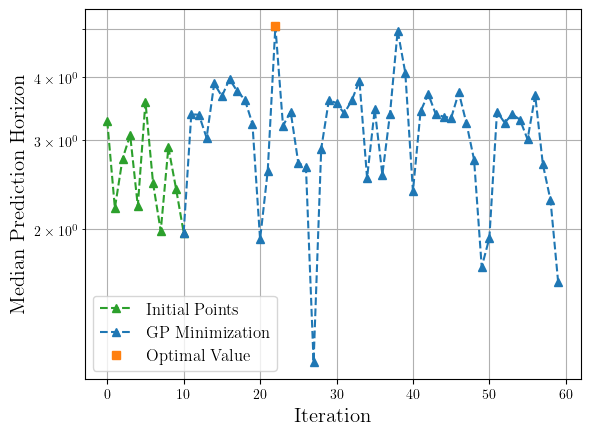

In [39]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

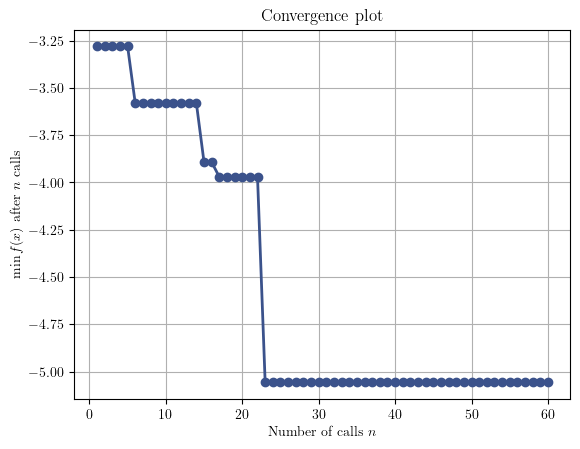

In [40]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [41]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

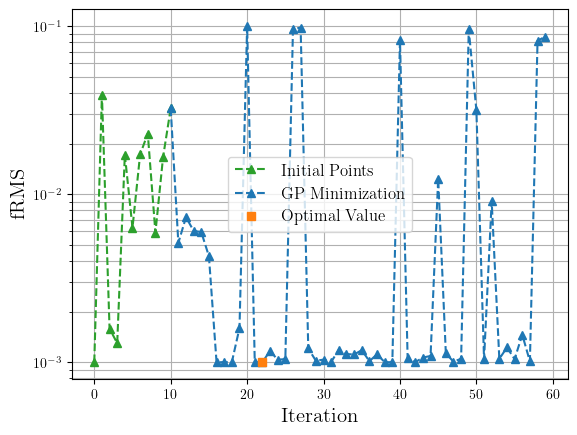

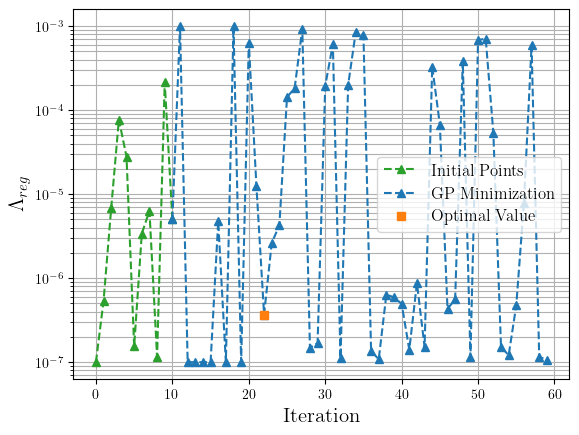

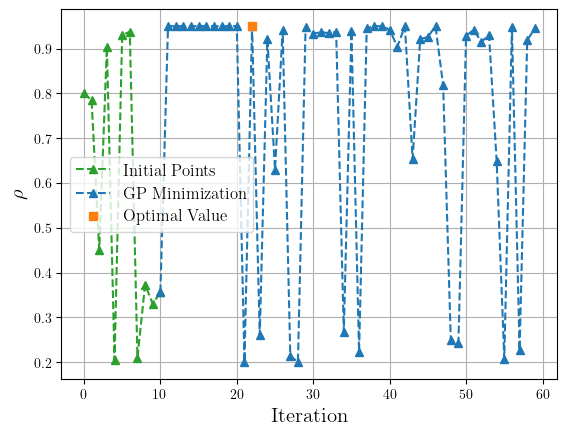

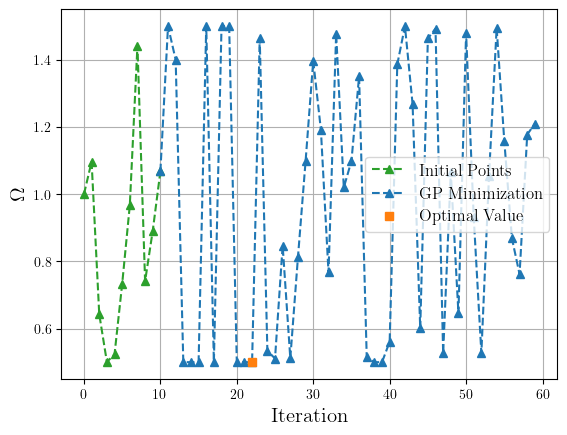

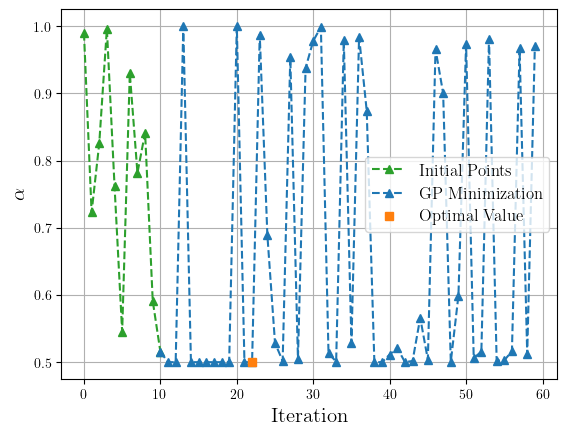

In [42]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
    # [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append([r'Degree of Connectivity', 'deg_of_connectivity', plt.plot])

for i in range(len(xoptim_names)):
    a = n_initial_points
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [43]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [44]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/prediction_horizons-testingdata.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [45]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [46]:
idx, dir_list[idx[0]]

(array([52]), 'test_ESN_022')

In [47]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

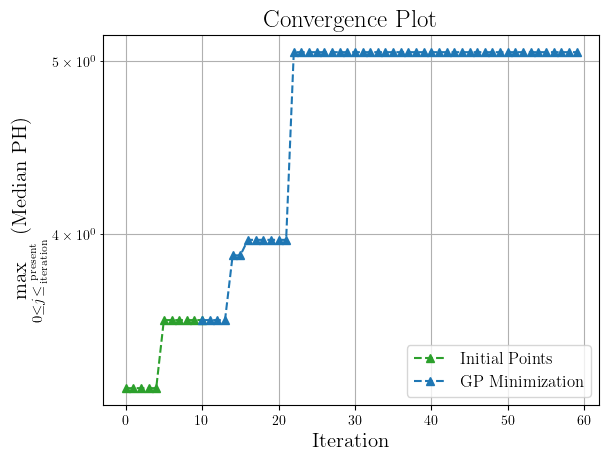

In [48]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation